In [1]:
#this script allows you to convert any earth map from python to civmap
#you can modify latitude,longitude and projection to get any earth map
#in the demonstration below I use basemap package
#technically u can use any map even non-map 
#u just have to map different pixel colors to terrains
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.basemap import Basemap
os.chdir('K:/ecole/github/televerser/civ6')

In [2]:
#create copy then rename
#i strongly encourage you to create a blank map then load it into python
#the directory of customized map from world builder
# C:\Users\your_user_name\Documents\My Games\Sid Meier's Civilization VI\Saves\WorldBuilder
os.system('copy nouveau.Civ6Map copie.Civ6Map')

#essentially civ6map is a sql database
os.rename('nouveau.Civ6Map','civ.db')

### global variables

In [3]:
#map terrain into different colors for viz
terrain2color={'TERRAIN_COAST': '#16396c',
 'TERRAIN_DESERT': '#b18e35',
 'TERRAIN_DESERT_HILLS': '#b18e35',
 'TERRAIN_DESERT_MOUNTAIN': '#b18e35',
 'TERRAIN_GRASS': '#2b3317',
 'TERRAIN_GRASS_HILLS': '#2b3317',
 'TERRAIN_GRASS_MOUNTAIN': '#2b3317',
 'TERRAIN_OCEAN': '#050d24',
 'TERRAIN_PLAINS': '#90aa6e',
 'TERRAIN_PLAINS_HILLS': '#90aa6e',
 'TERRAIN_PLAINS_MOUNTAIN': '#90aa6e',
 'TERRAIN_SNOW': '#eceeee',
 'TERRAIN_SNOW_HILLS': '#eceeee',
 'TERRAIN_SNOW_MOUNTAIN': '#eceeee',
 'TERRAIN_TUNDRA': '#a09b90',
 'TERRAIN_TUNDRA_HILLS': '#a09b90',
 'TERRAIN_TUNDRA_MOUNTAIN': '#a09b90'}

#map colors into different terrains
#remove ocean and mountain tiles for simplicity
color2terrain={
 '#90aa6e': 'TERRAIN_PLAINS',
 '#16396c': 'TERRAIN_COAST',
 '#b18e35': 'TERRAIN_DESERT',
 '#2b3317': 'TERRAIN_GRASS',
 '#eceeee': 'TERRAIN_SNOW',
 '#a09b90': 'TERRAIN_TUNDRA',}

#land and sea mask for sanity check
masque={
'#000000': 'TERRAIN_PLAINS',
'#FFFFFF': 'TERRAIN_COAST',}

### read map

In [4]:
#connect to sql database
con=sqlite3.connect("civ.db")

#show all tables
cursor=con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('MetaData',), ('Map',), ('MapAttributes',), ('Plots',), ('PlotAttributes',), ('PlotRivers',), ('PlotCliffs',), ('PlotResources',), ('PlotFeatures',), ('PlotImprovements',), ('PlotRoutes',), ('PlotOwners',), ('RevealedPlots',), ('StartPositions',), ('Units',), ('UnitAttributes',), ('Cities',), ('CityAttributes',), ('Districts',), ('DistrictAttributes',), ('Buildings',), ('Players',), ('PlayerAttributes',), ('ModProperties',), ('ModComponents',), ('ModComponent_Properties',), ('ModComponent_Items',), ('ModSettings',), ('ModSettings_Properties',), ('ModSettings_Items',), ('ModText',), ('ModDependencies',), ('GameConfig',), ('NamedRiverPlot',), ('NamedRiver',)]


In [5]:
#get map size
df=pd.read_sql('SELECT * FROM Map',con)
mapw=df['Width'].iloc[0]
maph=df['Height'].iloc[0]

In [6]:
#get map data
df=pd.read_sql('SELECT * FROM Plots',con)

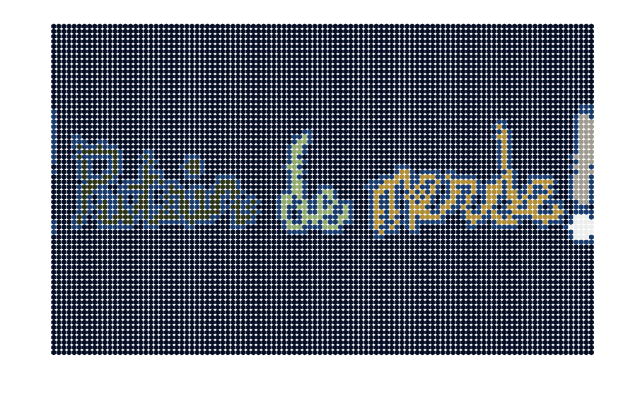

In [7]:
#viz existing map
map_colors=df['TerrainType'].apply(lambda x:terrain2color[x]).tolist()
ax=plt.figure(figsize=(mapw/10,maph/10)).add_subplot(111)
plt.scatter([j for i in range(maph) for j in range(mapw)],
    [i for i in range(maph) for j in range(mapw)],
    s=20,marker='h',
    c=map_colors)
plt.axis('off')
plt.show()

### create map

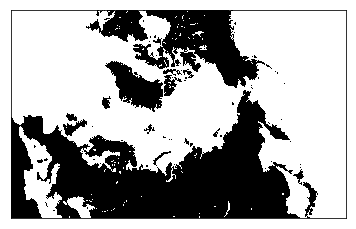

In [8]:
#scaler determines the cutoff latitude
scaler=120000

#create map
m=Basemap(projection='aeqd',
              lon_0=80,
              lat_0=90,
              width=mapw*scaler,
              height=maph*scaler)

#show land and sea in different colors
m.drawlsmask(land_color='k',
    ocean_color='w',)

#save image
plt.savefig('mask.png',bbox_inches='tight',
            pad_inches=-.05)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


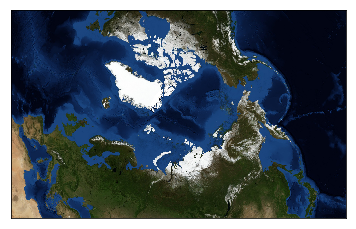

In [9]:
#scaler determines the cutoff latitude
scaler=120000

#create map
m=Basemap(projection='aeqd',
              lon_0=80,
              lat_0=90,
              width=mapw*scaler,
              height=maph*scaler)

#blue marble is my fav
#it is similar to google earth
#m.shadedrelief()
#the problem with shaded relief is
#it is harder to distinguish different terrains for computers
#m.etopo()
#the problem with etopo is
#brown represents mountains instead of desert
m.bluemarble()

#you can draw country border to assist you in true start location
#m.drawcountries()

#draw river for map creation is a bad idea
#since river is in a separate table from Plots
#m.drawrivers()

plt.savefig('trial.png',bbox_inches='tight',
            pad_inches=-.05)

In [10]:
#scale down into civmap
img=cv2.imread('trial.png')
new_img=cv2.resize(img,dsize=(mapw,maph),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('civ.png',new_img)

#scale down into civmap
img=cv2.imread('mask.png')
new_img=cv2.resize(img,dsize=(mapw,maph),
           interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('mask.png',new_img)

True

### basemap to civmap

In [11]:
#convert hex to rgb
def hex_to_rgb(hex):
  
    rgb=[]
    for i in (0,2,4):
        decimal = int(hex[i:i+2],16)
        rgb.append(decimal)
        
    return tuple(rgb)

In [12]:
#convert rgb to hex
def rgb_to_hex(rgb):
    return '#'+'%02x%02x%02x' % rgb

In [13]:
#assign color to fixed centroid
#based upon euclidean distance
def cluster_predict(img,color2terrain):
    
    #get dimension
    maph=img.shape[0]
    mapw=img.shape[1]
    
    #vertical flip
    img=np.flip(img,axis=0)
    
    #get hex color
    centroid_colors=[hex_to_rgb(i[1:]) for i in color2terrain.keys()]
    
    #repeat centroid colors
    repeated_arr=[np.repeat(np.array(i).reshape(1,-1),mapw*maph,axis=0) for i in centroid_colors]
    
    #compute sum of squared error
    sse_arr=[np.square(img.reshape(mapw*maph,3)[:,[2,1,0]]-i).sum(axis=1) for i in repeated_arr]
    
    #take the smallest sse as assigned color
    assignment=np.argmin(np.c_[sse_arr],axis=0)
    
    return assignment

In [14]:
#every assignment should follow the rule of land sea mask
#if it is land in lsmask
#any coast/ocean tile in assignment
#would be revert to the default land type in lsmask
#the same applies to coast/ocean in lsmask
def check_land_sea(assignment,lsmask,color2terrain):

    #avoid index starts at zero
    assignment+=1

    #make all coast/ocean tile negative
    idx4neg=[ind for ind,val in enumerate(assignment) if list(color2terrain.values())[val-1]=='TERRAIN_COAST']
    assignment[idx4neg]=-assignment[idx4neg]

    #convert 01 binary to -11 binary
    lsmask[lsmask==1]=-1
    lsmask[lsmask==0]=1

    #multiplication
    #any negative number indicates mismatch of land/sea type
    result=np.multiply(assignment,lsmask)

    #revert lsmask back to 01 binary
    #plus one to be consistent with result
    lsmask[lsmask==1]=0
    lsmask[lsmask==-1]=1
    lsmask+=1

    #revert mismatch to default land/sea type
    result[result<0]=lsmask[result<0]

    #minus one to revert index back to zero
    result-=1
    
    return result

In [15]:
#read image into numpy array
img=cv2.imread('mask.png',1)

#draw the border between land and sea
lsmask=cluster_predict(img,masque)

#read image into numpy array
img=cv2.imread('civ.png',1)

#get simplified colors
assignment=cluster_predict(img,color2terrain)

In [16]:
#sanity check on land/sea
result=check_land_sea(assignment,lsmask,color2terrain)

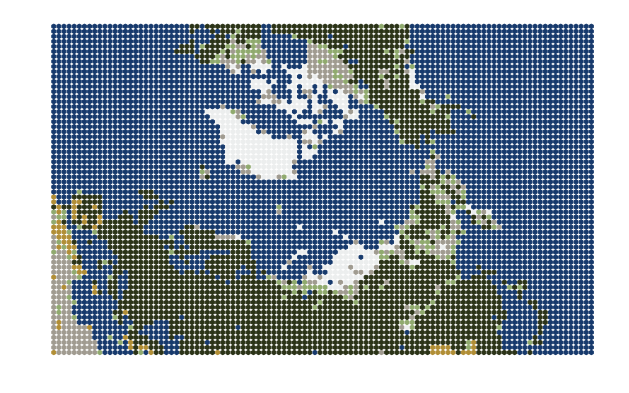

In [17]:
#map color to terrain
df['TerrainType']=[list(color2terrain.values())[i] for i in result]

#viz new map
map_colors=df['TerrainType'].apply(lambda x:terrain2color[x]).tolist()
ax=plt.figure(figsize=(mapw/10,maph/10)).add_subplot(111)
plt.scatter([j for i in range(maph) for j in range(mapw)],
    [i for i in range(maph) for j in range(mapw)],
    s=20,marker='h',
    c=map_colors)
plt.axis('off')
plt.show()

### update civmap database

In [18]:
#initialize continent and impassable
df['ContinentType']=''
df['IsImpassable']=0

In [19]:
#upsert into database
df.to_sql('Plots',con=con,if_exists='replace',index=False)

In [20]:
#remove all cliffs
con.execute("DELETE FROM PlotCliffs;");
con.commit()

In [21]:
#revert back to civ6map
con.close()
os.rename('civ.db','nouveau.Civ6Map')

In [22]:
#k means to get centroid colors
#useful when you prefer other types of viz to show topographic map

# from sklearn.cluster import KMeans
# X=img.reshape(mapw*maph,3)[:,[2,1,0]]
# clf=KMeans(n_clusters=6)
# clf.fit(X)
# centroids=[i for i in range(clf.cluster_centers_.shape[0])]
# for i in range(clf.cluster_centers_.shape[0]):
#     centroids[i]=rgb_to_hex(tuple([int(np.ceil(j)) for j in clf.cluster_centers_[i].tolist()]))
# print(centroids)
# plt.scatter(range(6),range(6),c=centroids,s=500)
# plt.show()